# Libraries

In [1]:
import pickle
import pandas as pd
import seaborn as sns
from os.path import exists
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
import datetime
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.sentiment import SentimentIntensityAnalyzer  # Import VADER
import re
import textstat
import nltk
nltk.download('averaged_perceptron_tagger')
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('vader_lexicon')
nltk.download('averaged_perceptron_tagger_eng')

from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
import pickle

import numpy as np






[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/nikhilramchandani/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/nikhilramchandani/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/nikhilramchandani/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/nikhilramchandani/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /Users/nikhilramchandani/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!


# Loading the Files

Download the csv files into the `data/` directory.

train.csv shape is  (1697533, 9)
test.csv shape is  (212192, 2)



                 Id  HelpfulnessNumerator  HelpfulnessDenominator  \
count  1.697533e+06          1.697533e+06            1.697533e+06   
mean   8.487660e+05          3.569048e+00            5.301422e+00   
std    4.900357e+05          1.727883e+01            2.024445e+01   
min    0.000000e+00          0.000000e+00            0.000000e+00   
25%    4.243830e+05          0.000000e+00            0.000000e+00   
50%    8.487660e+05          1.000000e+00            1.000000e+00   
75%    1.273149e+06          3.000000e+00            5.000000e+00   
max    1.697532e+06          6.084000e+03            6.510000e+03   

               Time         Score  
count  1.697533e+06  1.485341e+06  
mean   1.262422e+09  4.110517e+00  
std    1.289277e+08  1.197651e+00  
min    8.793792e+08  1.000000e+00  
25%    1.164413e+09  4.000000e+00  
50%    1.307491e+09  5.000000e+00  
75%    1.373242e+09  5.000000e+00  
max    1.406074e+09  5.

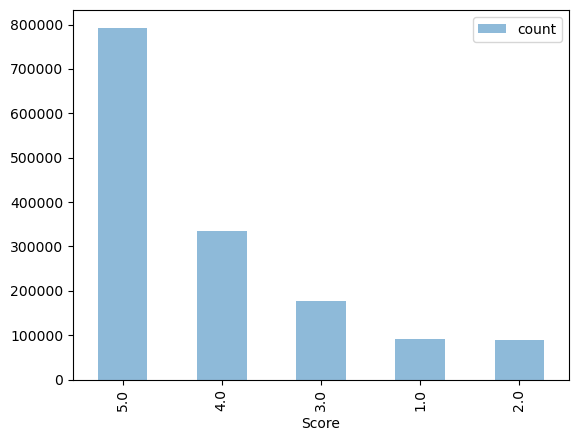


EVERYTHING IS PROPERLY SET UP! YOU ARE READY TO START


In [2]:
trainingSet = pd.read_csv("./data/train.csv")
testingSet = pd.read_csv("./data/test.csv")

print("train.csv shape is ", trainingSet.shape)
print("test.csv shape is ", testingSet.shape)

print()

# print(trainingSet.head())
print()
# print(testingSet.head())

print()

print(trainingSet.describe())

trainingSet['Score'].value_counts().plot(kind='bar', legend=True, alpha=.5)
print(trainingSet["Score"].value_counts())
plt.show()

print()
print("EVERYTHING IS PROPERLY SET UP! YOU ARE READY TO START")

# Adding Features

In [3]:
def add_features_to(df):
    # This is where you can do all your feature extraction

    df['Helpfulness'] = df['HelpfulnessNumerator'] / df['HelpfulnessDenominator']
    df['Helpfulness'] = df['Helpfulness'].fillna(0)


    df = add_time_features(df)
    df = add_text_length_features(df)
    df = add_summary_length_features(df)
    df = add_helpfulness_ratio(df)
    df = add_sentiment_features(df)
    df = add_pos_features(df)
    df = add_recency_feature(df)
    df = add_summary_text_similarity(df)
    df = add_readability_feature(df)
    df = add_sentence_length_feature(df)
    df = add_average_user_score(df)
    df = add_average_product_score(df)

    return df

def handle_missing_values(df):
    # Fill missing values with the median of the column
    df['Text'] = df['Text'].fillna('')
    df['Summary'] = df['Summary'].fillna('')
    return df



def add_time_features(df):
    df['Time'] = pd.to_datetime(df['Time'], unit='s')
    df['Year'] = df['Time'].dt.year
    df['Month'] = df['Time'].dt.month
    df['Day'] = df['Time'].dt.day
    df['DayOfWeek'] = df['Time'].dt.dayofweek
    return df


def add_text_length_features(df):
    df['TextLength'] = df['Text'].apply(lambda x: len(x.split()) if isinstance(x, str) else 0)  # Word Count
    df['TextCharCount'] = df['Text'].apply(lambda x: len(x) if isinstance(x, str) else 0)  # Character Count
    df['TextPunctCount'] = df['Text'].apply(lambda x: sum(1 for char in x if char in ['!', '?', '.', ',', ';', ':', '-', '(', ')']) if isinstance(x, str) else 0)  # Punctuation Count
    df['TextUpperCount'] = df['Text'].apply(lambda x: sum(1 for char in x if char.isupper()) if isinstance(x, str) else 0)  # Uppercase Count
    df['TextLowerCount'] = df['Text'].apply(lambda x: sum(1 for char in x if char.islower()) if isinstance(x, str) else 0)  # Lowercase Count
    return df

def add_summary_length_features(df):
    df['SummaryLength'] = df['Summary'].apply(lambda x: len(x.split()) if isinstance(x, str) else 0)  # Word Count
    df['SummaryCharCount'] = df['Summary'].apply(lambda x: len(x) if isinstance(x, str) else 0)  # Character Count
    df['SummaryPunctCount'] = df['Summary'].apply(lambda x: sum(1 for char in x if char in ['!', '?', '.', ',', ';', ':', '-', '(', ')']) if isinstance(x, str) else 0)  # Punctuation Count
    df['SummaryUpperCount'] = df['Summary'].apply(lambda x: sum(1 for char in x if char.isupper()) if isinstance(x, str) else 0)  # Uppercase Count
    df['SummaryLowerCount'] = df['Summary'].apply(lambda x: sum(1 for char in x if char.islower()) if isinstance(x, str) else 0)  # Lowercase Count
    return df

def add_helpfulness_ratio(df):
    df['HelpfulnessTextLengthRatio'] = df['Helpfulness'] / (df['TextLength'] + 1)
    df['HelpfulnessSummaryLengthRatio'] = df['Helpfulness'] / (df['SummaryLength'] + 1)
    return df


def add_sentiment_features(df):
    sia = SentimentIntensityAnalyzer()
    # Use VADER for sentiment analysis
    df['TextSentiment'] = df['Text'].apply(lambda x: sia.polarity_scores(x)['compound'] if isinstance(x, str) else 0)
    df['SummarySentiment'] = df['Summary'].apply(lambda x: sia.polarity_scores(x)['compound'] if isinstance(x, str) else 0)
    return df


def count_pos_tags(text):
    tokens = nltk.word_tokenize(text)
    pos_tags = nltk.pos_tag(tokens)
    pos_count = {'nouns': 0, 'verbs': 0, 'adjectives': 0, 'adverbs': 0}
    for word, pos in pos_tags:
        if pos.startswith('N'): pos_count['nouns'] += 1
        elif pos.startswith('V'): pos_count['verbs'] += 1
        elif pos.startswith('J'): pos_count['adjectives'] += 1
        elif pos.startswith('R'): pos_count['adverbs'] += 1
    return pos_count

def add_pos_features(df):
    pos_features = df['Text'].apply(lambda x: count_pos_tags(x) if isinstance(x, str) else {'nouns': 0, 'verbs': 0, 'adjectives': 0, 'adverbs': 0})
    df['NounCount'] = pos_features.apply(lambda x: x['nouns'])
    df['VerbCount'] = pos_features.apply(lambda x: x['verbs'])
    df['AdjectiveCount'] = pos_features.apply(lambda x: x['adjectives'])
    df['AdverbCount'] = pos_features.apply(lambda x: x['adverbs'])
    return df


def add_recency_feature(df):
    current_time = pd.Timestamp(datetime.datetime.now())
    df['Recency'] = (current_time - df['Time']).dt.days
    return df

def add_summary_text_similarity(df):
    vectorizer = TfidfVectorizer()
    text_tfidf = vectorizer.fit_transform(df['Text'].fillna(''))
    summary_tfidf = vectorizer.transform(df['Summary'].fillna(''))
    
    similarity = []
    for i in range(len(df)):
        if text_tfidf[i].nnz > 0 and summary_tfidf[i].nnz > 0:  # Check non-zero vector
            similarity.append(cosine_similarity(text_tfidf[i], summary_tfidf[i])[0][0])
        else:
            similarity.append(0)  # No similarity for empty or non-representative text
    df['TextSummarySimilarity'] = similarity
    return df


def add_readability_feature(df):
    df['TextReadability'] = df['Text'].apply(lambda x: textstat.flesch_kincaid_grade(x) if isinstance(x, str) else 0)
    df['SummaryReadability'] = df['Summary'].apply(lambda x: textstat.flesch_kincaid_grade(x) if isinstance(x, str) else 0)
    return df


def average_sentence_length(text):
    sentences = re.split(r'[.!?]+', text) if isinstance(text, str) else []
    num_sentences = len(sentences)
    total_words = len(text.split()) if isinstance(text, str) else 0
    return total_words / num_sentences if num_sentences > 0 else 0

def add_sentence_length_feature(df):
    df['AvgSentenceLengthText'] = df['Text'].apply(lambda x: average_sentence_length(x))
    df['AvgSentenceLengthSummary'] = df['Summary'].apply(lambda x: average_sentence_length(x))
    return df

def add_average_user_score(df):
    # Calculate average user score based on the first 1,114,005 rows
    avg_user_scores = df.iloc[:1114005].groupby('UserId')['Score'].mean()
    df['AvgUserScore'] = df['UserId'].map(avg_user_scores)
    df['AvgUserScore'] = df['AvgUserScore'].where(df['UserId'].isin(avg_user_scores.index), np.nan) 
    return df

def add_average_product_score(df):
    # Calculate average product score based on the first 1,114,005 rows
    avg_product_scores = df.iloc[:1114005].groupby('ProductId')['Score'].mean()
    df['AvgProductScore'] = df['ProductId'].map(avg_product_scores)
    df['AvgProductScore'] = df['AvgProductScore'].where(df['ProductId'].isin(avg_product_scores.index), np.nan) 
    return df

def text_clean(df):
    df['Text'] = df['Text'].str.lower()  # Convert to lowercase
    df['Summary'] = df['Summary'].str.lower()  # Convert to lowercase

    # Remove stopwords, special characters, and punctuation
    stopwords = set(['the', 'and', 'is', 'to', 'in', 'that', 'it', 'of', 'for', 'on', 'with'])  # Add more stopwords as needed
    df['Text'] = df['Text'].apply(lambda x: ' '.join([word for word in str(x).split() if word not in stopwords and word.isalnum()]))  # Remove stopwords and punctuation
    df['Summary'] = df['Summary'].apply(lambda x: ' '.join([word for word in str(x).split() if word not in stopwords and word.isalnum()]))  # Remove stopwords and punctuation

    # Stemming
    stemmer = PorterStemmer()
    df['Text'] = df['Text'].apply(lambda x: ' '.join([stemmer.stem(word) for word in str(x).split()]))  # Stemming
    df['Summary'] = df['Summary'].apply(lambda x: ' '.join([stemmer.stem(word) for word in str(x).split()]))  # Stemming

    # Text Feature Transformation using TF-IDF
    tfidf_vectorizer = TfidfVectorizer(max_features=1000)  # Adjust max_features as needed
    tfidf_matrix = tfidf_vectorizer.fit_transform(df['Text']).toarray()
    tfidf_df = pd.DataFrame(tfidf_matrix, columns=tfidf_vectorizer.get_feature_names_out())
    
    # Concatenate TF-IDF features with the original DataFrame
    df = pd.concat([df.reset_index(drop=True), tfidf_df.reset_index(drop=True)], axis=1)


    return df
# Load the feature extracted files if they've already been generated
if exists('./data/X_train.csv'):
    X_train = pd.read_csv("./data/X_train.csv")
if exists('./data/X_submission.csv'):
    X_submission = pd.read_csv("./data/X_submission.csv")

else:
    # Process the DataFrame
    train = add_features_to(trainingSet)
    train = text_clean(train)

    score_avg = train['Score'].iloc[:1114005].mean()
    train['AvgProductScore'].fillna(score_avg, inplace=True)
    train['AvgUserScore'].fillna(score_avg, inplace=True)


    # Merge on Id so that the submission set can have feature columns as well
    X_submission = pd.merge(train, testingSet, left_on='Id', right_on='Id')
    X_submission = X_submission.drop(columns=['Score_x'])
    X_submission = X_submission.rename(columns={'Score_y': 'Score'})

    # The training set is where the score is not null
    X_train =  train[train['Score'].notnull()]

    X_submission.to_csv("./data/X_submission.csv", index=False)
    X_train.to_csv("./data/X_train.csv", index=False)



## Adding After establishing X_train and X_submission


In [4]:

# Calculate review counts for the first 1,114,005 rows of the training set
user_review_counts = trainingSet.iloc[:1114005]['UserId'].value_counts()
product_review_counts = trainingSet.iloc[:1114005]['ProductId'].value_counts()

# Add UserReviewCount to X_train
X_train['UserReviewCount'] = X_train['UserId'].map(user_review_counts)

# Add ProductReviewCount to X_train
X_train['ProductReviewCount'] = X_train['ProductId'].map(product_review_counts)

# Add UserReviewCount to X_submission
X_submission['UserReviewCount'] = X_submission['UserId'].map(user_review_counts)

# Add ProductReviewCount to X_submission
X_submission['ProductReviewCount'] = X_submission['ProductId'].map(product_review_counts)

In [5]:
X_train['ProductReviewCount'].fillna(0, inplace=True)
X_train['UserReviewCount'].fillna(0, inplace=True)

X_submission['ProductReviewCount'].fillna(0, inplace=True)
X_submission['UserReviewCount'].fillna(0, inplace=True)

/var/folders/dk/vyk6_yxx6rx4y27dlhv_cvq80000gn/T/ipykernel_41705/3777632517.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  X_train['ProductReviewCount'].fillna(0, inplace=True)
/var/folders/dk/vyk6_yxx6rx4y27dlhv_cvq80000gn/T/ipykernel_41705/3777632517.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values

In [6]:
# Add HelpfulnessDifference to X_train
X_train['HelpfulnessDifference'] = X_train['HelpfulnessDenominator'] - X_train['HelpfulnessNumerator']


# Add HelpfulnessDifference to X_submission
X_submission['HelpfulnessDifference'] = X_submission['HelpfulnessDenominator'] - X_submission['HelpfulnessNumerator']


In [7]:
# Calculate the number of exclamation marks in the Text and Summary columns
trainingSet['ExclamationCountText'] = trainingSet['Text'].apply(lambda x: x.count('!') if isinstance(x, str) else 0)
trainingSet['ExclamationCountSummary'] = trainingSet['Summary'].apply(lambda x: x.count('!') if isinstance(x, str) else 0)

# Add ExclamationCountText to X_train
X_train['ExclamationCountText'] = X_train['Id'].map(trainingSet.set_index('Id')['ExclamationCountText'])

# Add ExclamationCountSummary to X_train
X_train['ExclamationCountSummary'] = X_train['Id'].map(trainingSet.set_index('Id')['ExclamationCountSummary'])

# Add ExclamationCountText to X_submission
X_submission['ExclamationCountText'] = X_submission['Id'].map(trainingSet.set_index('Id')['ExclamationCountText'])

# Add ExclamationCountSummary to X_submission
X_submission['ExclamationCountSummary'] = X_submission['Id'].map(trainingSet.set_index('Id')['ExclamationCountSummary'])


In [8]:
# Calculate variance of scores based on UserId and ProductId for the first 1,114,005 rows
user_variance = trainingSet.iloc[:1114005].groupby('UserId')['Score'].var()
product_variance = trainingSet.iloc[:1114005].groupby('ProductId')['Score'].var()

# Add UserScoreVariance to X_train
X_train['UserScoreVariance'] = X_train['UserId'].map(user_variance)

# Add ProductScoreVariance to X_train
X_train['ProductScoreVariance'] = X_train['ProductId'].map(product_variance)

# Add UserScoreVariance to X_submission
X_submission['UserScoreVariance'] = X_submission['UserId'].map(user_variance)

# Add ProductScoreVariance to X_submission
X_submission['ProductScoreVariance'] = X_submission['ProductId'].map(product_variance)

X_train['UserScoreVariance'].fillna(0, inplace=True)
X_train['ProductScoreVariance'].fillna(0, inplace=True)

X_submission['UserScoreVariance'].fillna(0, inplace=True)
X_submission['ProductScoreVariance'].fillna(0, inplace=True)


/var/folders/dk/vyk6_yxx6rx4y27dlhv_cvq80000gn/T/ipykernel_41705/3393090663.py:17: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  X_train['UserScoreVariance'].fillna(0, inplace=True)
/var/folders/dk/vyk6_yxx6rx4y27dlhv_cvq80000gn/T/ipykernel_41705/3393090663.py:18: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting value

# Check Data

In [9]:
nan_columns = X_train.columns[X_train.isna().any()].tolist()
print(nan_columns)

['Summary', 'Text']


In [10]:
nan_columns = X_submission.columns[X_submission.isna().any()].tolist()
print(nan_columns)

['Summary', 'Text', 'Score']


In [ ]:
average_product_scores = {}
average_user_scores = {}

for row in X_train.iterrows():
    if row[1]['ProductId'] not in average_product_scores:
        average_product_scores[row[1]['ProductId']] = row[1]['AvgProductScore']
    elif average_product_scores[row[1]['ProductId']] != row[1]['AvgProductScore']:
        print('Different average product scores for the same product')
    if row[1]['UserId'] not in average_user_scores:
        average_user_scores[row[1]['UserId']] = row[1]['AvgUserScore']
    elif average_user_scores[row[1]['UserId']] != row[1]['AvgUserScore']:
        print('Different average user scores for the same user')

    
    

In [8]:
global_avg_set = set()
for row in X_submission.iterrows():
    if row[1]['ProductId'] not in average_product_scores:
        global_avg_set.add(row[1]['AvgProductScore'])
    elif average_product_scores[row[1]['ProductId']] != row[1]['AvgProductScore']:
        print('Different average product scores for the same product')
    if row[1]['UserId'] not in average_user_scores:
        global_avg_set.add(row[1]['AvgUserScore'])
    elif average_user_scores[row[1]['UserId']] != row[1]['AvgUserScore']:
        print('Different average user scores for the same user')

In [ ]:
print(len(global_avg_set))

# Practice Models

In [12]:
# train_size = 200000
# global_avg = 4.111444742169021

# average_product_scores = {}
# average_user_scores = {}

# for index, row in X_train[:int(train_size * 0.75)].iterrows():
#     if row['ProductId'] not in average_product_scores:
#         average_product_scores[row['ProductId']] = row['AvgProductScore']
#     if row['UserId'] not in average_user_scores:
#         average_user_scores[row['UserId']] = row['AvgUserScore']

# for index, row in X_train[int(train_size * 0.75):train_size].iterrows():
#     if row['ProductId'] in average_product_scores:
#         X_train.loc[index, 'AvgProductScore'] = average_product_scores[row['ProductId']]
#     else:
#         X_train.loc[index, 'AvgProductScore'] = global_avg
#     if row['UserId'] in average_user_scores:
#         X_train.loc[index, 'AvgUserScore'] = average_user_scores[row['UserId']]
#     else:
#         X_train.loc[index, 'AvgUserScore'] = global_avg

# Train with an imbalance

In [ ]:
# minimum number of reviews for a rating


# Sample + Split into training and testing set

In [9]:
# Split training set into training and testing set

X_train_subset = X_train
X_train_subset = X_train_subset[(X_train_subset['Helpfulness'] >= 0) & (X_train_subset['Helpfulness'] <= 1)]
print(X_train_subset.shape)
X_train, X_test, Y_train, Y_test = train_test_split(
    X_train_subset.drop(columns=['Score']),
    X_train_subset['Score'],
    test_size=1/4.0,
    random_state=0
)

(1485335, 1047)


In [11]:
print(X_train.shape)
print(X_test.shape)
print(Y_train.shape)
print(Y_test.shape)


(1114001, 1044)
(371334, 1044)
(1114001,)
(371334,)


In [12]:
features = X_train.columns[X_train.columns != 'Score'].tolist()

# Feature Selection

In [22]:
non_numeric_columns = X_train.select_dtypes(exclude=['number']).columns.tolist()
other_unwanted_columns = ['HelpfulnessNumerator', 'HelpfulnessDenominator']
all_unwanted_columns = non_numeric_columns + other_unwanted_columns
features = [col for col in X_train.columns if col != 'Score' and col not in all_unwanted_columns]  # Updated line
features = ['TextSentiment', 'SummarySentiment','AvgProductScore', 'AvgUserScore','TextSummarySimilarity', 'TextReadability', 'SummaryReadability', 'AvgSentenceLengthText', 'AvgSentenceLengthSummary', 'NounCount', 'VerbCount', 'AdjectiveCount', 'AdverbCount', 'Recency', 'Helpfulness', 'HelpfulnessTextLengthRatio', 'HelpfulnessSummaryLengthRatio', 'HelpfulnessDifference', 'UserReviewCount', 'ProductReviewCount', 'Year', 'Month', 'Day', 'DayOfWeek', 'TextLength', 'TextCharCount', 'TextPunctCount', 'TextUpperCount', 'TextLowerCount', 'SummaryLength', 'SummaryCharCount', 'SummaryPunctCount', 'SummaryUpperCount', 'SummaryLowerCount','ExclamationCountSummary','ExclamationCountText', 'UserScoreVariance', 'ProductScoreVariance']
features = ['TextSentiment', 'SummarySentiment','AvgProductScore', 'AvgUserScore','TextSummarySimilarity', 'TextReadability', 'AvgSentenceLengthText', 'NounCount', 'VerbCount', 'AdverbCount', 'Recency', 'Helpfulness', 'HelpfulnessDifference', 'UserReviewCount', 'ProductReviewCount', 'TextLength', 'TextCharCount', 'TextUpperCount', 'TextLowerCount', 'SummaryCharCount', 'ExclamationCountText', 'ExclamationCountSummary', 'UserScoreVariance', 'ProductScoreVariance']
features = ['TextSentiment', 'SummarySentiment','AvgProductScore', 'AvgUserScore', 'Recency', 'HelpfulnessDifference', 'UserReviewCount', 'ProductReviewCount',  'UserScoreVariance', 'ProductScoreVariance','AvgSentenceLengthText','SummaryCharCount']
X_train_select = X_train[features]
X_test_select = X_test[features]
X_submission_select = X_submission[features]


print(X_train_select.shape)
print(X_test_select.shape)
print(X_submission_select.shape)

(1114001, 12)
(371334, 12)
(212192, 12)


In [23]:
# Train a Random Forest model
rf_model = RandomForestClassifier(n_estimators=100,max_depth=20, random_state=0)
rf_model.fit(X_train_select, Y_train)

# Get feature importances
importances = rf_model.feature_importances_

# Create a DataFrame for visualization
feature_importance_df = pd.DataFrame({
    'Feature': features,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Plot feature importances
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df)
plt.title('Feature Importance from Random Forest')
plt.show()



In [18]:
print(feature_importance_df)

                  Feature  Importance
3            AvgUserScore    0.176985
8       UserScoreVariance    0.138344
2         AvgProductScore    0.124963
1        SummarySentiment    0.074305
0           TextSentiment    0.070607
5   HelpfulnessDifference    0.065954
9    ProductScoreVariance    0.065109
4                 Recency    0.046314
13         TextLowerCount    0.044493
7      ProductReviewCount    0.040345
10  AvgSentenceLengthText    0.040014
11       SummaryCharCount    0.038050
6         UserReviewCount    0.037907
12        TextReadability    0.036611


In [20]:
Y_test_predictions = rf_model.predict(X_test_select)
print("Accuracy on testing set = ", accuracy_score(Y_test, Y_test_predictions))

model = rf_model

Accuracy on testing set =  0.6704018484706491


Accuracy on testing set =  0.6338713934086294
Accuracy on testing set =  0.6348112480947072
Accuracy on testing set =  0.6377762337949124
Accuracy on testing set =  0.6374396096236811
Accuracy on testing set =  0.6696693542740497
Accuracy on testing set =  0.6711908955280153
Accuracy on testing set =  0.671734880188725


# Model Creation

In [ ]:
# model = RandomForestClassifier(n_estimators=400, random_state=0).fit(X_train_select, Y_train)
# Y_test_predictions = model.predict(X_test_select)
# print("Accuracy on testing set = ", accuracy_score(Y_test, Y_test_predictions))

# with open('./random_forest_model_all.pkl', 'wb') as file:
#     pickle.dump(model, file)



Accuracy on testing set =  0.62872

# OLD Code

In [ ]:
# # Define a function to train and evaluate models
# def train_and_evaluate_models(X_train, Y_train, X_test, Y_test):
#     models = {
#         'RandomForest': RandomForestClassifier(),
#         'KNN': KNeighborsClassifier(),
#         'SVM': SVC()
#     }
    
#     # Define parameter grids for each model
#     param_grids = {
#         'RandomForest': {
#             'n_estimators': [200],
#             'max_depth': [30]
#         },
#         'KNN': {
#             'n_neighbors': [5, 100],
#             'weights': ['uniform', 'distance']
#         },
#         'SVM': {
#             'C': [1, 100],
#             'kernel': ['linear', 'rbf']
#         }
#     }
    
#     best_models = {}
#     best_scores = {}
    
#     for model_name, model in models.items():
#         grid_search = GridSearchCV(model, param_grids[model_name], cv=5, scoring='accuracy')
#         grid_search.fit(X_train, Y_train)
        
#         # Get the best model and score
#         best_models[model_name] = grid_search.best_estimator_
#         best_scores[model_name] = grid_search.best_score_
        
#         print(f"Best model for {model_name}: {best_models[model_name]} with score: {best_scores[model_name]}")
        
#         # Save the best model to a pickle file
#         with open(f'./{model_name}_best_model.pkl', 'wb') as f:
#             pickle.dump(best_models[model_name], f)

#     return best_models

# # Train and evaluate models
# best_model = train_and_evaluate_models(X_train_select, Y_train, X_test_select, Y_test)

# # Save the best model to a pickle file


# print("Best model saved to best_model.pkl")

# Model Evaluation

Accuracy on testing set =  0.6707842535291678


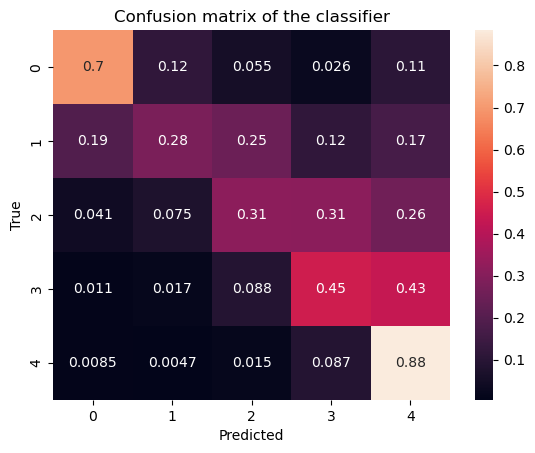

In [32]:
# Evaluate your model on the testing set
print("Accuracy on testing set = ", accuracy_score(Y_test, Y_test_predictions))

# Plot a confusion matrix
cm = confusion_matrix(Y_test, Y_test_predictions, normalize='true')
sns.heatmap(cm, annot=True)
plt.title('Confusion matrix of the classifier')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Create submission file

In [14]:
# Create the submission file
X_submission['Score'] = model.predict(X_submission_select)
submission = X_submission[['Id', 'Score']]
submission.to_csv("./data/submission.csv", index=False)

In [21]:
score_counts = X_submission['Score'].value_counts()
print(score_counts)

Score
5.0    134251
4.0     41017
3.0     17136
1.0     12433
2.0      7355
Name: count, dtype: int64
